In [131]:
import math
import numpy as np
import json
import pandas as pd
import glob
import torch
from src.utils import enumerate_binary_inputs

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from src.constants import OUTPUTS_DIR

SMALL_SIZE = 8

plt.rc("font", size=SMALL_SIZE)
plt.rc("axes", titlesize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)

# Encoder + Decoder Training Plot

In [113]:
experiment_file_1 = OUTPUTS_DIR / "train_neural_decoder_block_len_100_long_new.json"
experiment_file_2 = OUTPUTS_DIR / "train_neural_decoder_block_len_100_long_new_2_1.json"
exp_files = [experiment_file_1, experiment_file_2]

In [114]:
training_runs = []
i = 0
for exp_file in exp_files:
    with open(exp_file, "r") as e:
        results = json.load(e)
    for d in results["data"]:
        if "results" not in d:
            continue
        
        for res in d["results"]:
            if "xe__mean" in res:
                res["type"] = "validation"
                res["step"] = i
            else:
                res["type"] = "training"
                res["step"] = i
                i += 1
        training_results = pd.DataFrame([res for res in d["results"] if res["type"] == "training"])        
        training_runs.append(training_results)

dec_training = pd.concat(training_runs, axis=0)

training_select_cols = ["xe", "step"]
dec_training = dec_training[training_select_cols]


display(dec_training.head())

,xe,step
0,0.695503,0
1,0.694594,1
2,0.693140,2
3,0.692065,3
4,0.691617,4


In [115]:
experiment_file_1 = OUTPUTS_DIR / "train_turbo_table_batch_random_2.json"
exp_files = [experiment_file_1]
arg_hash = "7f7a61dd4c93cfaeb103d0093fcc98f5959ca30b"

tae_benchmark = OUTPUTS_DIR / "estimate_ce_tae_cont.json"

In [116]:
training_runs = []
i = 0
for exp_file in exp_files:
    with open(exp_file, "r") as e:
        results = json.load(e)
    for d in results["data"]:
        if "results" not in d:
            continue
        if d["preamble"]["argument_hash"] != arg_hash:
            continue
        
        for res in d["results"]:
            if "xe__mean" in res:
                res["type"] = "validation"
                res["step"] = i
            else:
                res["type"] = "training"
                # if "step" not in res:
                #     res["step"] = i
                i += 1
        training_results = pd.DataFrame([res for res in d["results"] if res["type"] == "training"])        
        training_runs.append(training_results)

enc_training = pd.concat(training_runs, axis=0)

training_select_cols = ["ce", "step"]
enc_training = enc_training[training_select_cols].drop_duplicates(subset=["step"])


display(enc_training.head())

,ce,step
0,0.068630,0
1,0.041794,1
2,0.043143,2
3,0.025392,3
4,0.020663,4


In [117]:
with open(tae_benchmark, "r") as e:
    results = json.load(e)
benchmark_ce_mean = results["data"][0]["results"]["ce__mean"]
benchmark_ce_err = results["data"][0]["results"]["ce__err"]

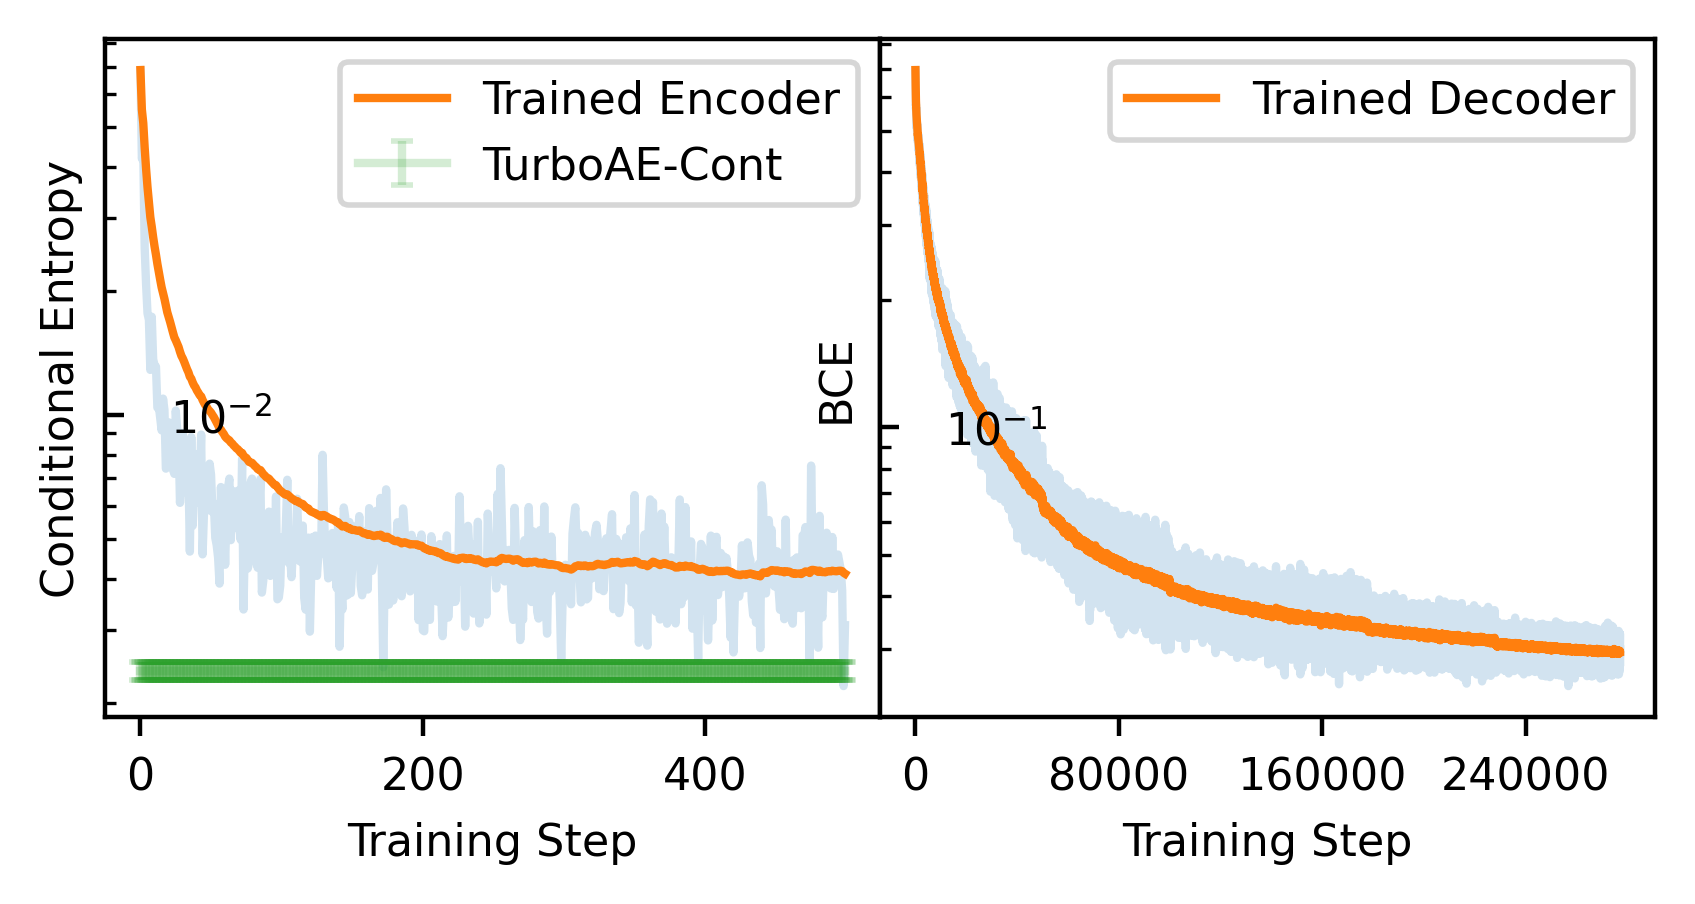

In [118]:
def make_encoder_training_plot(training_df, benchmark_mean, benchmark_err, ax):
    capsize = 2
    
    ax.plot(
        training_df["step"], 
        training_df["ce"], 
        linestyle='-',
        zorder=-5,
        alpha=0.2
    )
    ax.plot(
        training_df["step"], 
        training_df["ce"].ewm(com=50.0).mean(), 
        linestyle='-',
        zorder=-4,
        label=f"Trained Encoder"
    )
    bds = pd.merge(training_df["step"], pd.DataFrame([{"ce__mean": benchmark_mean, "ce__err": benchmark_err}]), how="cross")
    ax.errorbar(
        bds["step"], 
        bds["ce__mean"], 
        yerr=bds["ce__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"TurboAE-Cont",
        alpha=0.2
    )
    ax.set_yscale('log')
    ax.set_xlabel('Training Step')
    ax.set_ylabel("Conditional Entropy")
    ax.tick_params(axis="y", which="both", direction="in", pad=-30)
    ax.legend()
    
    return ax

def make_decoder_training_plot(training_df, ax):
    capsize = 2
    
    ax.plot(
        training_df["step"], 
        training_df["xe"], 
        linestyle='-',
        zorder=-5,
        alpha=0.2
    )
    ax.plot(
        training_df["step"], 
        training_df["xe"].ewm(com=50.0).mean(), 
        linestyle='-',
        zorder=-4,
        label="Trained Decoder"
    )
    ax.set_yscale('log')
    ax.set_ylabel("BCE")
    ax.set_xlabel('Training Step')
    ax.tick_params(axis="y", which="both", direction="in", pad=-30)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    # ax.xaxis.set_ticklabels([0, None, 100000, None, 200000, None])
    ax.legend()
    return ax

def make_enc_dec_training_plot(dec_training_df, enc_training_df, benchmark_mean, benchmark_err):
    fig, axs = plt.subplots(nrows=1, ncols=2, dpi=400, figsize=(5, 2.2))
    fig.subplots_adjust(wspace=0, hspace=0)
    make_encoder_training_plot(enc_training_df, benchmark_mean, benchmark_err, axs[0])
    make_decoder_training_plot(dec_training_df, axs[1])
    return fig

fig = make_enc_dec_training_plot(dec_training, enc_training, benchmark_ce_mean, benchmark_ce_err)
# display(fig)
fig.savefig("../figs/encoder_decoder_learning_curve.png", bbox_inches="tight")

# FC Evolution during Training

In [136]:
model_fp = '../models/train_turbo_table_block_len_16_7f7a61dd4c93cfaeb103d0093fcc98f5959ca30b.pt.fourier'

In [137]:
def plot_single_fourier(ax_sub, step: int, block: int, color: str, fourier_coefs):
    yLegend = [0.8, 0.6,]
    xLegend = 0
    coefs = fourier_coefs[step // 10, :, block]
    x_vals = np.arange(fourier_coefs.shape[1])
    bar_plot = ax_sub.bar(x=x_vals, height=coefs, color=color)
    ax_sub.set_xticks(list(range(0, 32, 8)))
    # ax_sub.xaxis.set_ticklabels([None] + list(range(8, 33, 8)))
    ax_sub.set_yticks([-1, 0, 1])
    ax_sub.yaxis.set_ticklabels([None, 0, 1])
    largest = np.argsort(np.abs(coefs))[::-1][:2]
    for j,index in enumerate(largest):
        if np.abs(coefs)[index] < 0.05:
            continue
        xCoord = index - 1.0
        yCoord_base = coefs[index]
        if 0.9 >= yCoord_base > 0:
            yCoord = yCoord_base + 0.05
        elif 0 >= yCoord_base > -0.75:
            yCoord = yCoord_base - 0.25
        elif yCoord_base <= -0.75:
            yCoord = 0.05
        else:
            yCoord = -0.25
            
        ax_sub.text(xCoord, yCoord, f'{j+1}')
        binaryIndex = format(index, 'b').zfill(5)
        ax_sub.text(xLegend, yLegend[j], f"{j+1}:{'  ' if index <= 9 else ''}{index}:{binaryIndex}")
    
    return ax_sub

def plot_fourier_bar_evolution(fourier_coefs, steps = None):
    colors = ['b', 'r', 'g', 'm']
    window = int(math.log2(fourier_coefs.shape[1]))
    if steps is None:
        steps = [-10]
    
    ncols = len(steps)
    nrows = 3
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey="row", sharex="col", dpi=400)
    fig.supylabel("Fourier Coefficient", fontsize=SMALL_SIZE, x=0.05)
    fig.supxlabel("Fourier Coefficient/Parity Index (0 through 32)", fontsize=SMALL_SIZE, y=0.04)
    fig.subplots_adjust(wspace=0, hspace=0)
    # ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    
    x_vals = np.arange(fourier_coefs.shape[1])
    print(fourier_coefs.shape)
    for block in range(3):
        for step_ind in range(len(steps)):
            step = steps[step_ind]
            ax_sub = axs[block, step_ind]
            if step_ind == 0:
                ax_sub.set_ylabel(f"Block {block + 1}")
            if block == 0:
                ax_sub.set_title(f"Step {step}")
            plot_single_fourier(ax_sub=ax_sub, step=step, block=block, color=colors[step_ind % len(colors)], fourier_coefs=fourier_coefs)
    
    return fig    
    
    

(51, 32, 3)


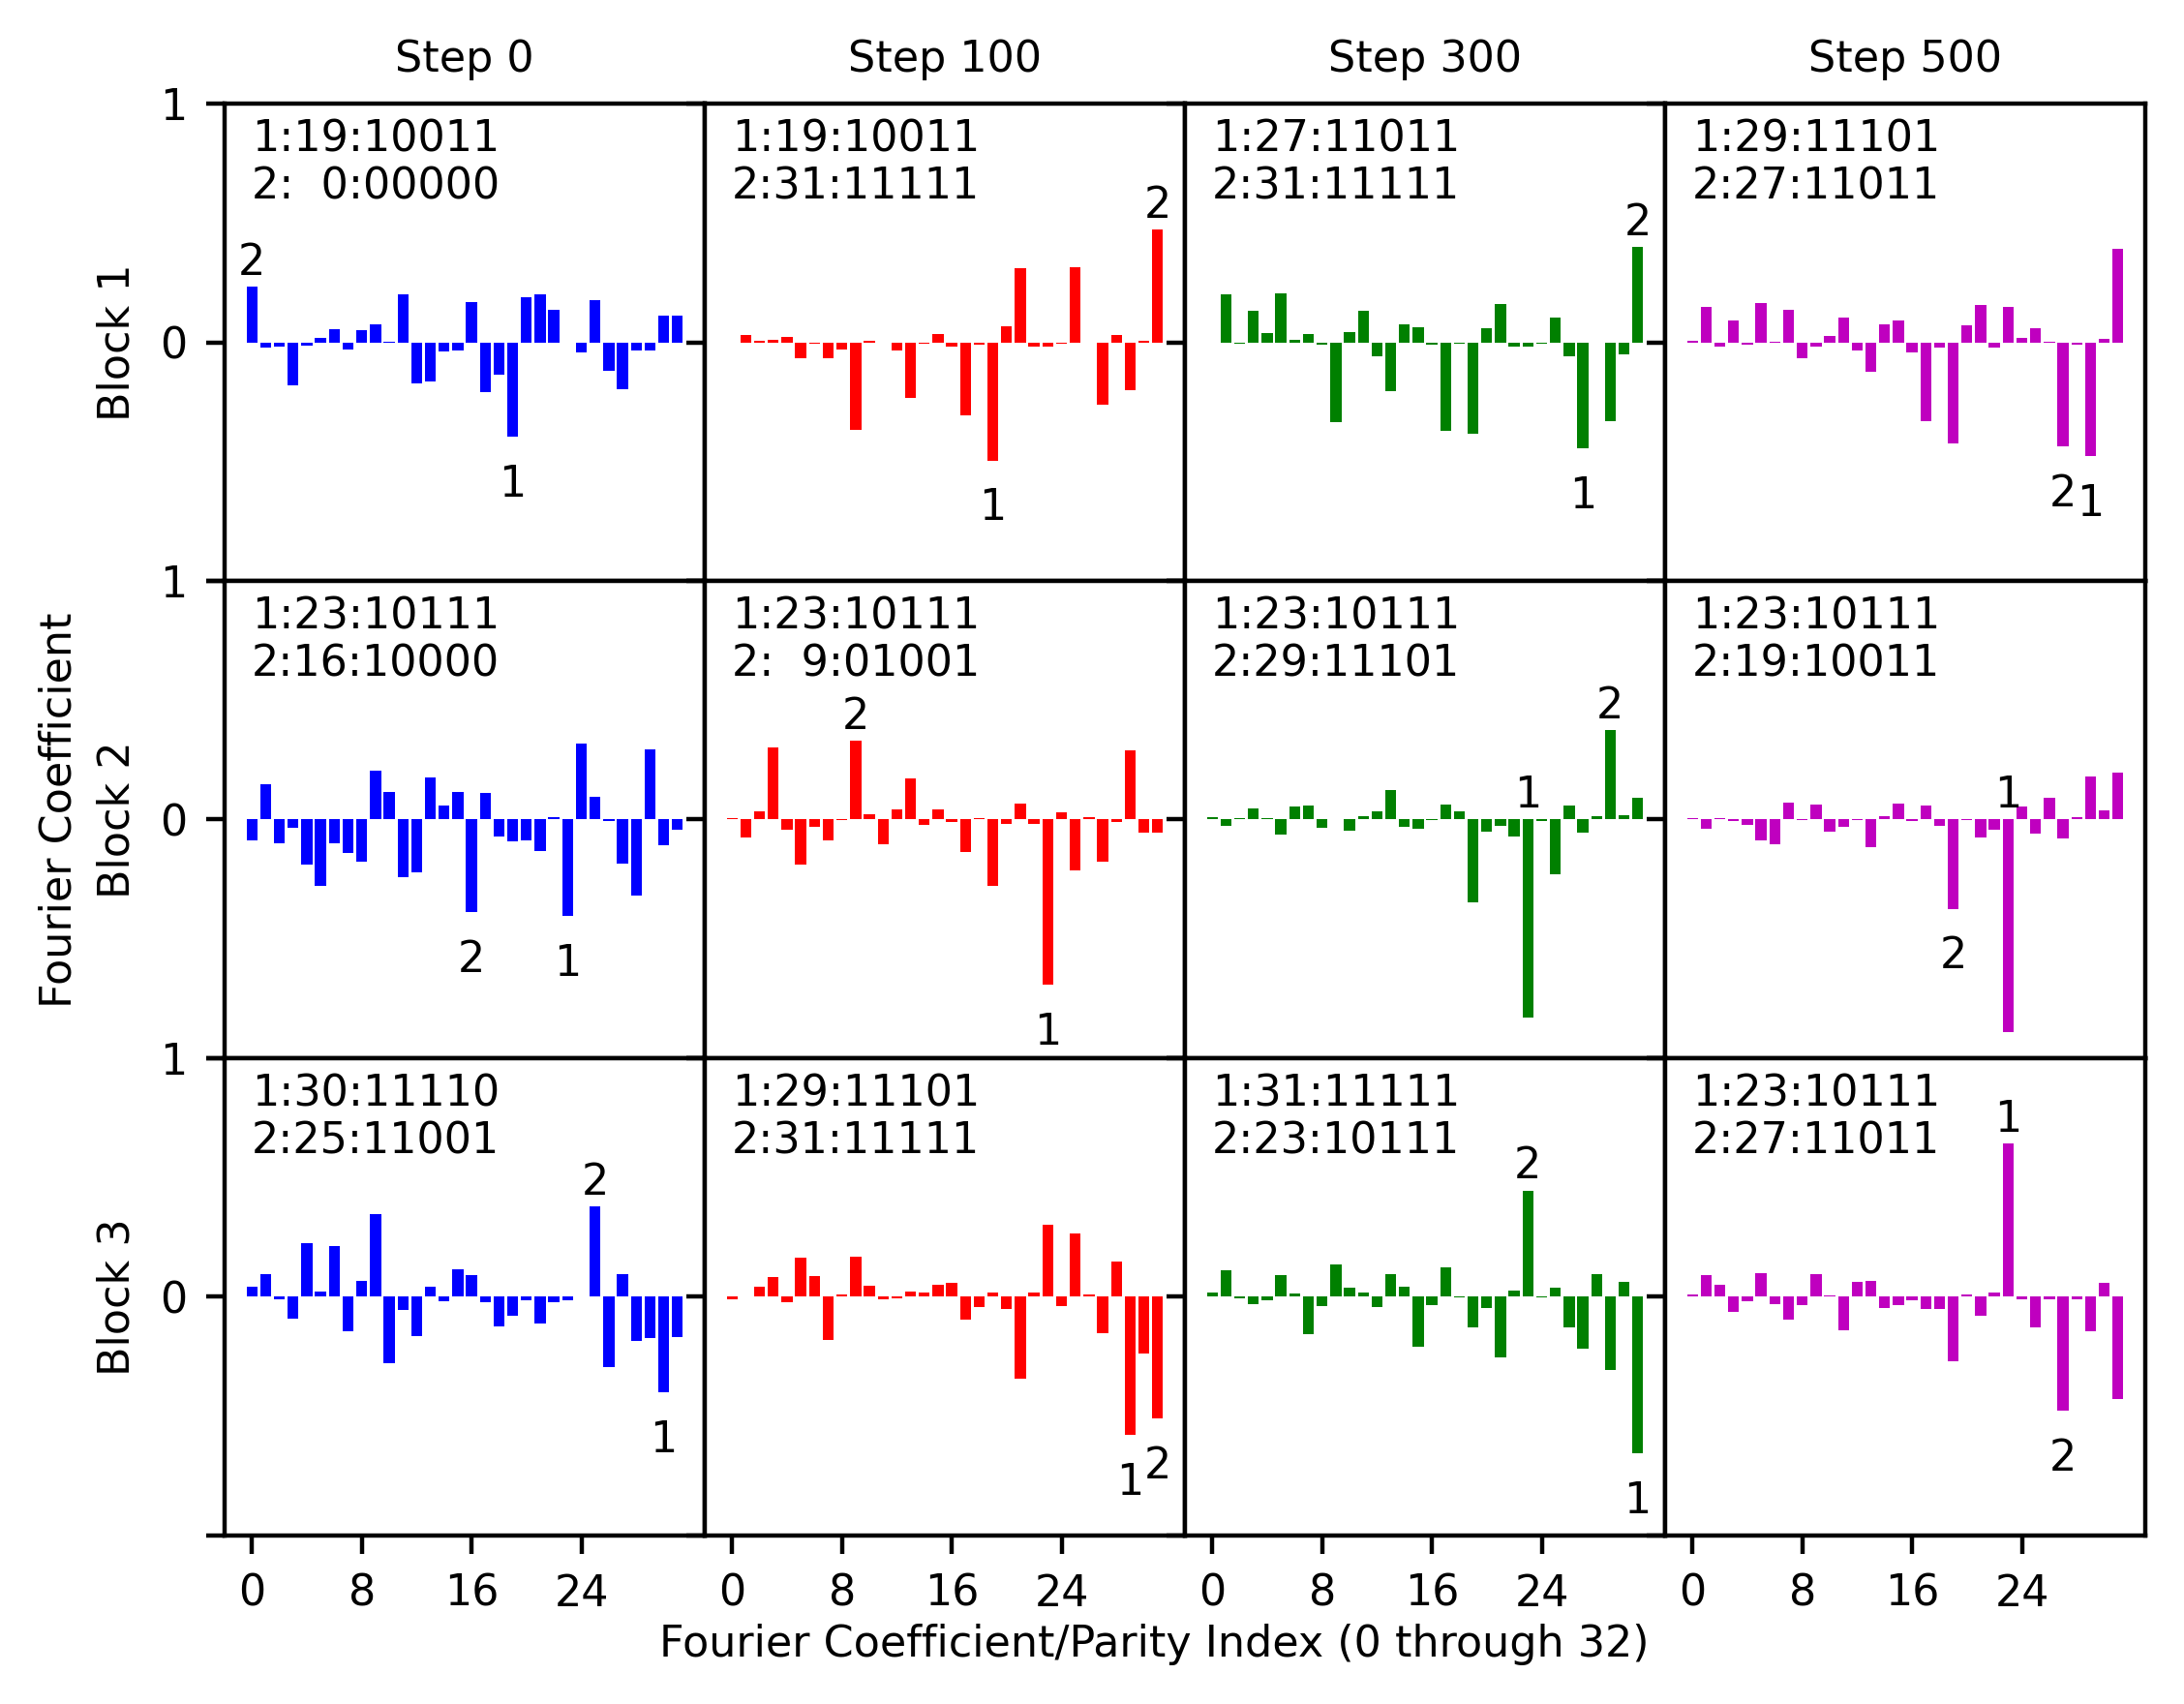

In [138]:
import torch

s_data = torch.load(model_fp)
k1= "noninterleaved"
k2 = "interleaved"
params = torch.stack([torch.cat([param_dict[k1], param_dict[k2]], dim=1) for param_dict in s_data], dim=0)
fig = plot_fourier_bar_evolution(params.detach().numpy(), steps=[0, 100, 300, 500])

fig.savefig("../figs/fourier_coef_train.png", bbox_inches="tight")
# display(fig)

# Parity FC Evolution and Training

In [122]:
experiment_file_1 = OUTPUTS_DIR / "train_turbo_table_batch_random.json"
experiment_file_2 = OUTPUTS_DIR / "train_turbo_table_fourier_batch_random.json"
experiment_file_3 = OUTPUTS_DIR / "train_turbo_table_batch_random_2.json"
exp_files = [experiment_file_1, experiment_file_2, experiment_file_3]
arg_hash = "da6fa1e7295ac4bd38e45caffc120570e0020b28"
model_fp = f'../models/train_turbo_table_block_len_16_{arg_hash}.pt.fourier'

tae_benchmark = OUTPUTS_DIR / "estimate_ce_tae_cont.json"


In [123]:
with open(tae_benchmark, "r") as e:
    results = json.load(e)
benchmark_ce_mean = results["data"][0]["results"]["ce__mean"]
benchmark_ce_err = results["data"][0]["results"]["ce__err"]

In [124]:
training_runs = []
i = 0
for exp_file in exp_files:
    with open(exp_file, "r") as e:
        results = json.load(e)
    for d in results["data"]:
        if "results" not in d:
            continue
        if d["preamble"]["argument_hash"] != arg_hash:
            continue
        
        for res in d["results"]:
            if "xe__mean" in res:
                res["type"] = "validation"
                res["step"] = i
            else:
                res["type"] = "training"
                # if "step" not in res:
                #     res["step"] = i
                i += 1
        training_results = pd.DataFrame([res for res in d["results"] if res["type"] == "training"])        
        training_runs.append(training_results)

enc_training = pd.concat(training_runs, axis=0)

training_select_cols = ["ce", "step"]
enc_training = enc_training[training_select_cols].drop_duplicates(subset=["step"])


display(enc_training.head())

,ce,step
0,0.010573,0
1,0.013356,1
2,0.009351,2
3,0.012628,3
4,0.012531,4


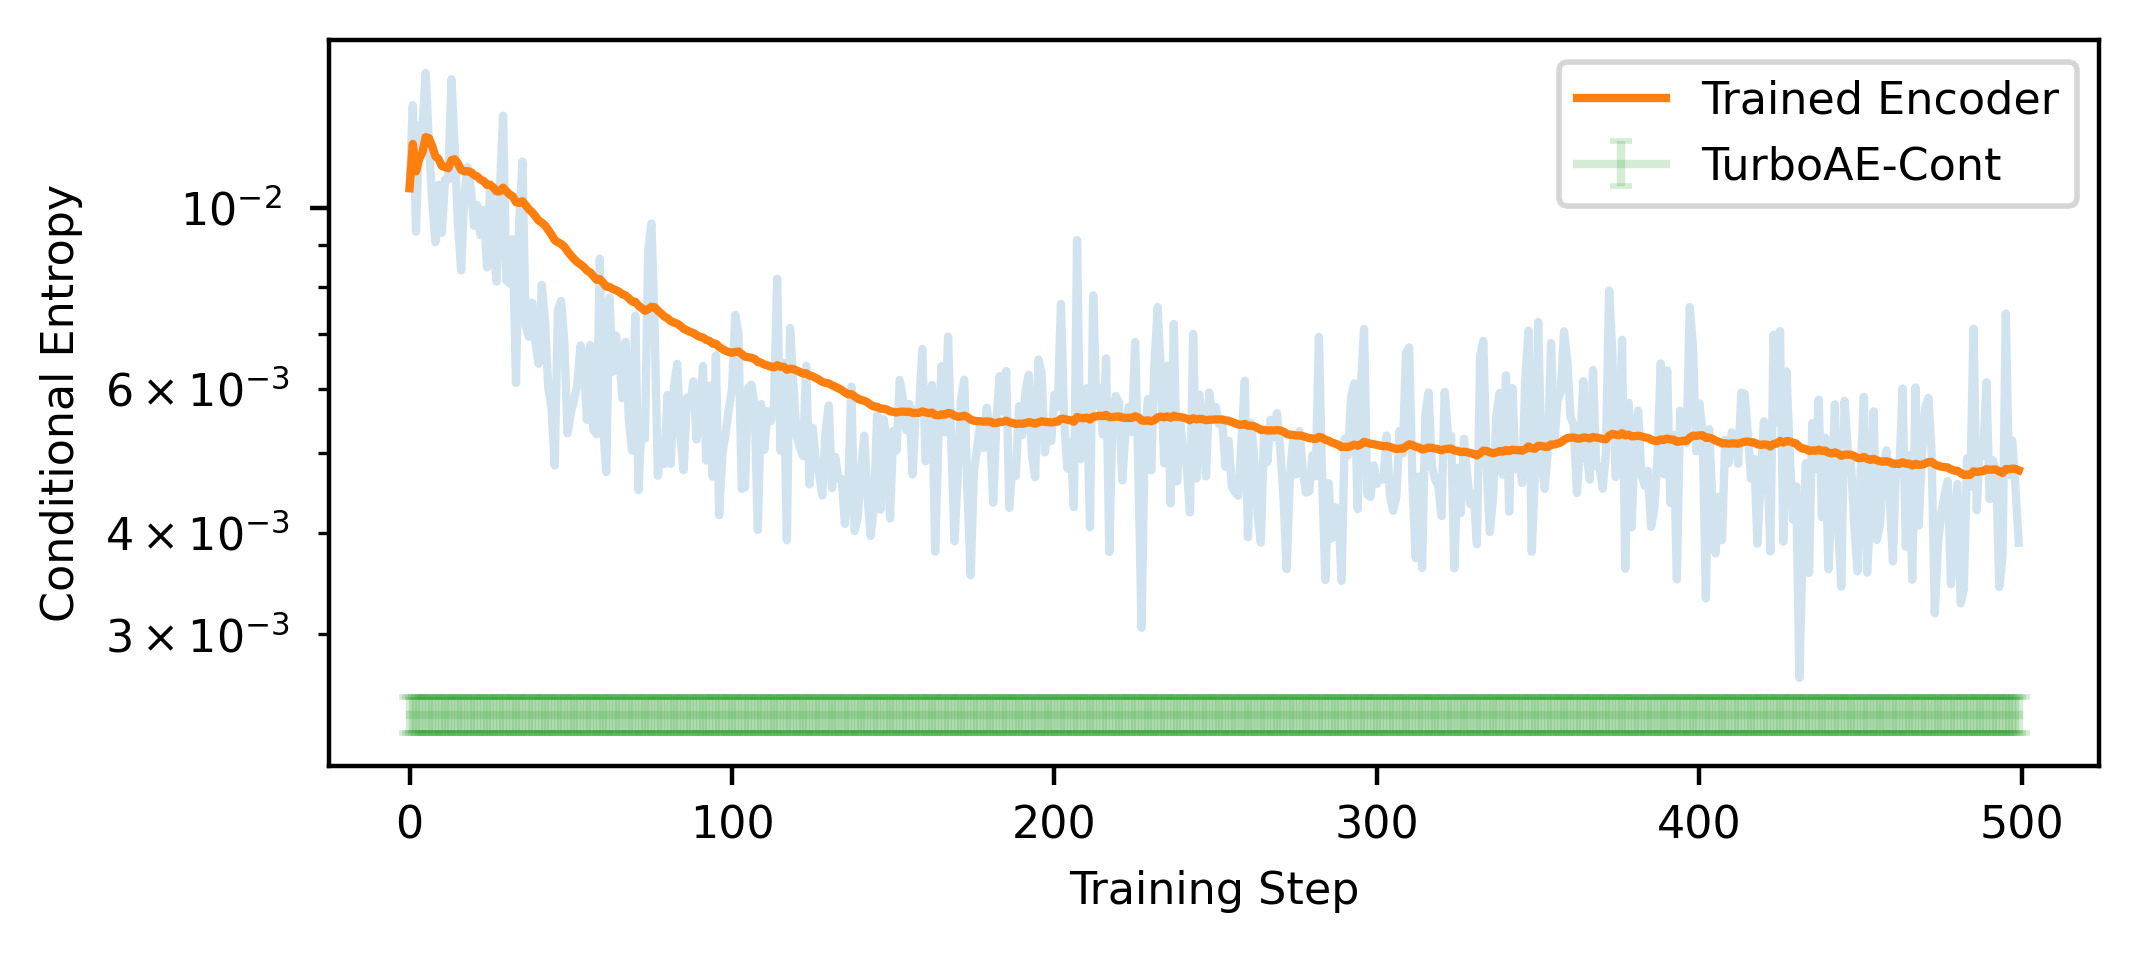

In [125]:
def parity_training_plot(training_df, benchmark_mean, benchmark_err):
    fig = plt.figure(dpi=400, figsize=(5, 2.2))
    ax = fig.add_axes([0.11, 0.17, .885, .825])  # Last two terms control height and width
    ax = make_encoder_training_plot(training_df, benchmark_mean, benchmark_err, ax)
    ax.tick_params(axis="y", which="both", direction="out", pad=5)
    return fig
    

# def parity_training_plot(training_df, fourier_coefs, benchmark_mean, benchmark_err):
#     fig = plt.figure(constrained_layout=True, dpi=400)
#     axs = fig.subplot_mosaic(
#         [["train", "fc_s0_0", "fc_s1_0", "fc_s2_0"], 
#          ["train", "fc_s0_1", "fc_s1_1", "fc_s2_1"], 
#          ["train", "fc_s0_2", "fc_s1_2", "fc_s2_2"]], 
#         gridspec_kw={"width_ratios": [2, 1, 1, 1], 'wspace':0, 'hspace':0}
#     )
#     make_encoder_training_plot(training_df, benchmark_mean, benchmark_err, axs["train"])
#     colors = ['b', 'r', 'g', 'm']
#     steps = [0, 100, 500]
#     for block in range(3):
#         for step_ind in range(len(steps)):
#             step = steps[step_ind]
#             ax_sub = axs[f"fc_s{step_ind}_{block}"]
#             if step_ind == 0:
#                 ax_sub.set_ylabel(f"Block {block}")
#             if block == 0:
#                 ax_sub.set_title(f"Step {step}")
#             plot_single_fourier(ax_sub=ax_sub, step=step, block=block, color=colors[step_ind % len(colors)], fourier_coefs=fourier_coefs)
#     return fig
    


fig = parity_training_plot(training_df=enc_training, benchmark_mean=benchmark_ce_mean, benchmark_err=benchmark_ce_err)
fig.savefig("../figs/parity_train_curve.png", bbox_inches="tight")

(51, 32, 3)


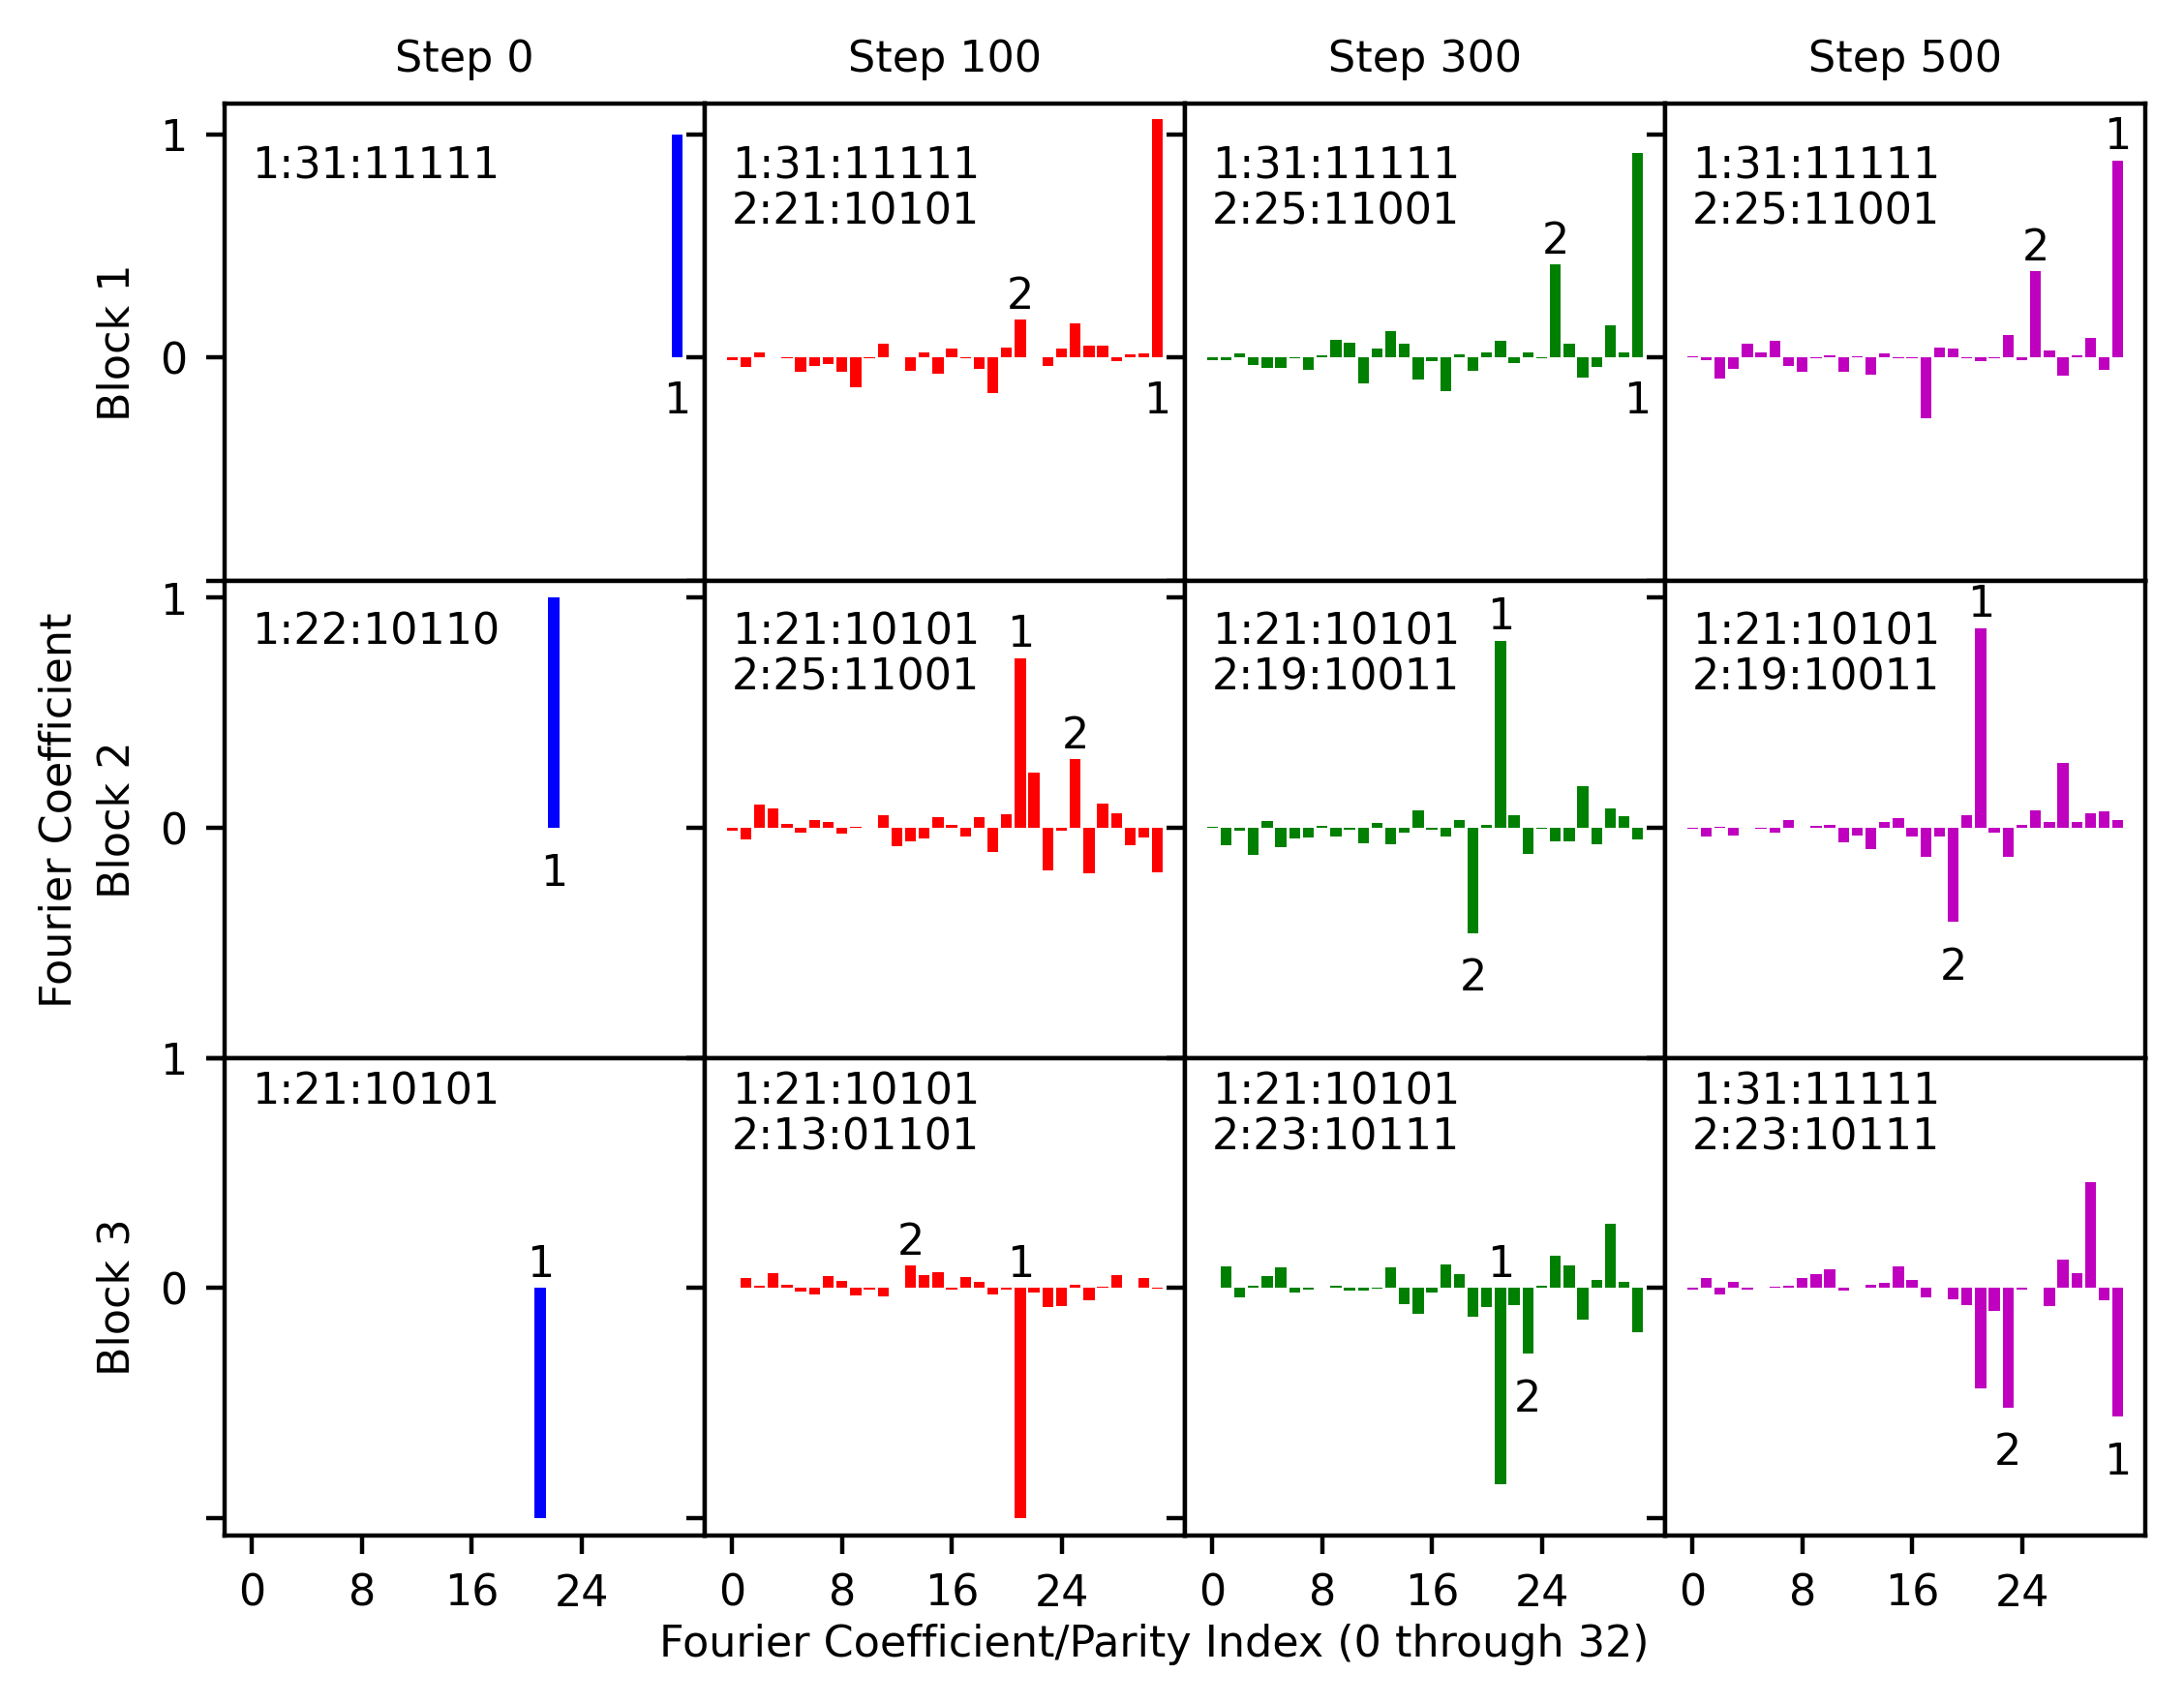

In [139]:
import torch

arg_hash = "da6fa1e7295ac4bd38e45caffc120570e0020b28"
model_fp = f'../models/train_turbo_table_block_len_16_{arg_hash}.pt.fourier'

s_data = torch.load(model_fp)
k1= "noninterleaved"
k2 = "interleaved"
params = torch.stack([torch.cat([param_dict[k1], param_dict[k2]], dim=1) for param_dict in s_data], dim=0).detach().numpy()
params[0] = params[0] * (np.abs(params[0]) >= 0.05).astype(float)

fig = plot_fourier_bar_evolution(params, steps = [0, 100, 300, 500])
fig.savefig("../figs/parity_train_fc.png", bbox_inches="tight")

# SNR ber plots

In [127]:
experiment_file_1 = OUTPUTS_DIR / "estimate_xe_bcjr_2.json"
experiment_file_2 = OUTPUTS_DIR / "estimate_xe_bcjr_trained.json"
experiment_file_3 = OUTPUTS_DIR / "estimate_xe_bcjr.json"
experiment_file_4 = OUTPUTS_DIR / "estimate_ber_neural.json"
experiment_file_5 = OUTPUTS_DIR / "estimate_ber_neural_tae.json"
exp_files = [experiment_file_1, experiment_file_2 ,experiment_file_3, experiment_file_4, experiment_file_5]

# name_interleaver = [["conv_15_7_00", "sample_random"], ["turboae_cont_exact_nobd", "turboae"], ["turboae_binary_exact_nobd", "turboae"], ['trained_encoder', 'fixed']]
name_interleaver = [["conv_15_7_00", "sample_random"], ['trained_encoder', 'fixed'], ["turboae_cont_exact_nn", "turboae"]]

In [128]:
snr_res = []
for exp_file in exp_files:
    with open(exp_file, "r") as e:
        results = json.load(e)
    for d in results["data"]:
        if not ([d["preamble"]["args"]["encoder_name"], d["preamble"]["args"]["interleaver_type"]] in name_interleaver):
            continue
        
        sample_res = pd.DataFrame([{"decoder": d["preamble"]["decoder_type"], "encoder": d["preamble"]["args"]["encoder_name"], "snr": d["preamble"]["args"]["snr"], "ber__mean": d["results"]["ber__mean"], "ber__err": d["results"]["ber__err"]}])

        snr_res.append(sample_res)

snr_df = pd.concat(snr_res, axis=0)
display(snr_df)

,decoder,encoder,snr,ber__mean,ber__err
0,iterated_regular,trained_encoder,4.0,1.905699e-06,9.526128e-08
0,iterated_regular,trained_encoder,3.5,4.680952e-06,2.327534e-07
0,iterated_regular,trained_encoder,3.0,1.130000e-05,5.586252e-07
0,iterated_regular,trained_encoder,2.5,2.710588e-05,1.319276e-06
0,iterated_regular,trained_encoder,2.0,6.259999e-05,2.964934e-06
0,iterated_regular,trained_encoder,1.5,1.550000e-04,7.700379e-06
0,iterated_regular,trained_encoder,1.0,3.512000e-04,1.606049e-05
0,iterated_regular,trained_encoder,0.5,9.789999e-04,4.718760e-05
0,iterated_regular,trained_encoder,0.0,3.201066e-03,1.152391e-04
0,iterated_regular,trained_encoder,-0.5,1.036427e-02,2.359146e-04


In [129]:
snr_df["decoder"].unique()

array(['iterated_regular', 'hazzys', 'neural'], dtype=object)

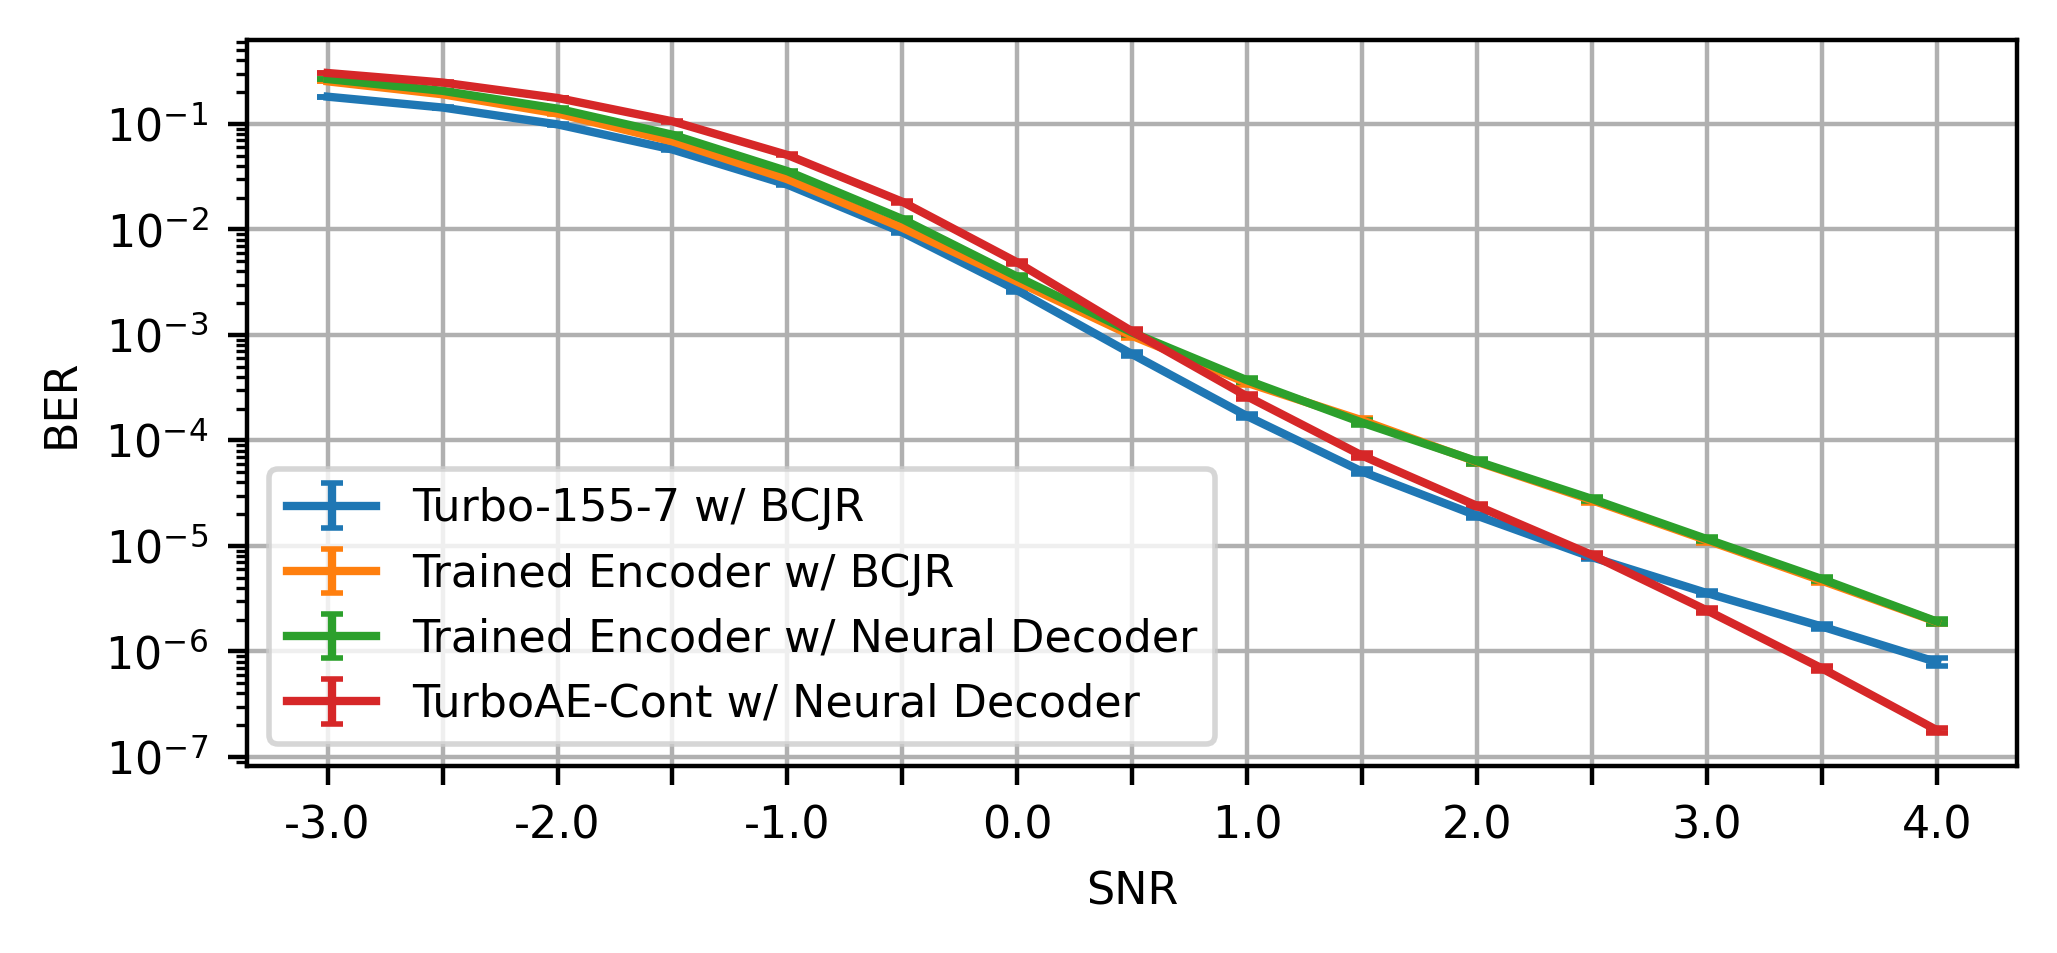

In [130]:
encoder_to_label = {
    "conv_15_7_00": "Turbo-155-7",
    "turboae_cont_exact_nobd": "TurboAE-Cont w/ BCJR",
    "turboae_binary_exact_nobd": "TurboAE-Binary w/ BCJR",
    "trained_encoder": "Trained Encoder",
    "turboae_cont_exact_nn": "TurboAE-Cont"
}

def plot_ber(
    snr_df    
):

    fig = plt.figure(dpi=400, figsize=(5, 2.2))
    ax = fig.add_axes([0.11, 0.17, .885, .825])  # Last two terms control height and width
    capsize = 2
    # axes.spines['right'].set_visible(not hide_right)
    # axes.spines['top'].set_visible(not hide_top)
    # axes.set_yscale('log')
    # axes.xaxis.set_minor_locator(AutoMinorLocator(2))
    # if axes_titles:
    ax.set_xlabel('SNR')
    ax.set_ylabel('BER')
    
    ax.set_yscale('log')
    ax.set_xticks(np.arange(-3.0, 4.5, 0.5))
    labeled = np.arange(-3.0, 4.5, 0.5, dtype="object")
    labeled[1::2] = None
    ax.xaxis.set_ticklabels(labeled)
    
    logfmt = mpl.ticker.LogFormatterSciNotation(base=10.0, labelOnlyBase=True)
    ax.yaxis.set_major_formatter(logfmt)
    ax.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())
    
    # ax.tick_params(axis="y",direction="out", pad=-30, which='both')
    # ax.tick_params(axis="x",direction="in", pad=-13, which='both')
        
    for (encoder, decoder), snr_result in snr_df.groupby(["encoder" ,"decoder"]):
        partial_title = encoder_to_label[encoder]
        rest_title = " w/ Neural Decoder" if decoder == "neural" else " w/ BCJR"
        title = partial_title + rest_title
        ax.errorbar(
            snr_result["snr"], 
            snr_result["ber__mean"], 
            yerr=snr_result["ber__err"], 
            linestyle='-',
            capsize=capsize,
            label=title
        )
    
    ax.legend()
    # ax.set_title("BER vs SNR")
    return fig

# fig.savefig(f'{channel_type}_ber_results.png')
fig = plot_ber(snr_df=snr_df)
plt.grid()
fig.savefig("../figs/ber_vs_snr.png")